Getting Dataset

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [17]:
! cp kaggle.json ~/.kaggle/

In [18]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

In [ ]:
! unzip /content/face-mask-12k-images-dataset.zip

In [ ]:
!pip install wandb

Libraries

In [1]:
import cv2
import wandb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
wandb.init(project='Face Mask Detection')

accuracy,▁▇██
epoch,▁▃▆█
loss,█▂▁▁
val_accuracy,▁▁▄█
val_loss,█▄▂▁
accuracy,0.982
best_epoch,3
best_val_loss,0.0131
epoch,3
loss,0.0522
val_accuracy,1.0


Data

In [3]:
train_dataset_path = '/content/Face Mask Dataset/Train'
validation_dataset_path = '/content/Face Mask Dataset/Validation'

width = height = 224
batch_size = 32

idg = ImageDataGenerator(
    rescale = 1./255,

    horizontal_flip=True,
    brightness_range=(0.7,1.3),
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    
    validation_split=0.2
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)
val_data = idg.flow_from_directory(
    validation_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

Found 8000 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


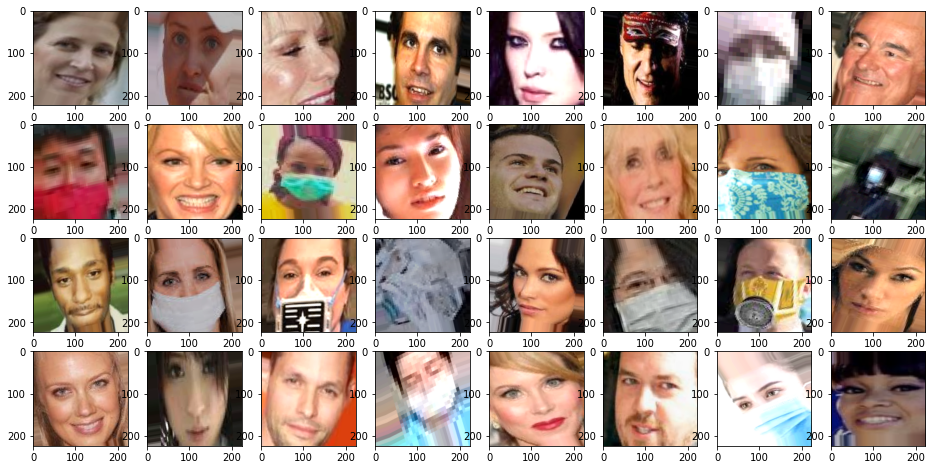

In [4]:
some_images = next(train_data)
X = some_images[0]
Y = some_images[1]

plt.figure(figsize=(16, 8))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i])

Model

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(width, height, 3),
    pooling='avg'
)

In [6]:
for layer in base_model.layers[:-2]:
    layer.trainable = False

In [7]:
model = tf.keras.models.Sequential([
    base_model,
    Dropout(0.25),  
    Dense(2, activation="softmax")
])

Model Summary

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

Train

In [10]:
model.fit(train_data, validation_data=val_data, epochs=4, callbacks=[WandbCallback()])

Epoch 1/4
250/250 [==============================] - 132s 506ms/step - loss: 0.1346 - accuracy: 0.9495 - val_loss: 0.0552 - val_accuracy: 0.9875 - _timestamp: 1648279753.0000 - _runtime: 195.0000
Epoch 2/4
250/250 [==============================] - 126s 502ms/step - loss: 0.0646 - accuracy: 0.9784 - val_loss: 0.0336 - val_accuracy: 0.9875 - _timestamp: 1648279893.0000 - _runtime: 335.0000
Epoch 3/4
250/250 [==============================] - 125s 501ms/step - loss: 0.0512 - accuracy: 0.9811 - val_loss: 0.0164 - val_accuracy: 0.9937 - _timestamp: 1648280018.0000 - _runtime: 460.0000
Epoch 4/4
250/250 [==============================] - 127s 506ms/step - loss: 0.0522 - accuracy: 0.9820 - val_loss: 0.0131 - val_accuracy: 1.0000 - _timestamp: 1648280145.0000 - _runtime: 587.0000


Save Model

In [12]:
model.save('FaceMask-MobileNetV2.h5')

Test

In [13]:
test_dataset_path = '/content/Face Mask Dataset/Test'
width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale=1./255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size=(width, height),
    class_mode="categorical",
    batch_size=batchSize
)

Found 992 images belonging to 2 classes.


In [15]:
model.evaluate(test_data)

31/31 [==============================] - 3s 98ms/step - loss: 0.0284 - accuracy: 0.9919


[0.028394415974617004, 0.9919354915618896]